In [1]:
import sys
sys.path.append('..') # Search for custom module in the top level. 

# Import my custom modules.
from allens_quantum_package.functions import * 
from allens_quantum_package.operators import *

from qiskit import *
from qiskit.quantum_info import state_fidelity
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit_experiments.framework import ExperimentData
from qiskit_experiments.library.tomography import MitigatedTomographyAnalysis, MitigatedStateTomography, TomographyAnalysis
from qiskit_experiments.library.tomography.basis import PauliMeasurementBasis
from qiskit_experiments.library.characterization.analysis import LocalReadoutErrorAnalysis
from qiskit_ibm_runtime import QiskitRuntimeService

import scipy
from numpy import set_printoptions, radians, ndarray, pi, degrees, radians
from random import randint
from collections import namedtuple

import itertools
from itertools import product

In [2]:
# Set the floating point diplay precision to 2 decimal places, sufficient for our purposes.
set_printoptions(precision=3)

# Initialise the Qiskit runtime service. 
service = QiskitRuntimeService()

In [2]:
states = [
    (radians(-88), radians(79)),
    (radians(32), radians(-167)),
    (radians(140), radians(125))
]

In [3]:
def build_circuit(theta, phi) -> QuantumCircuit:
    circ = QuantumCircuit(7)
    
    # Route on first layer
    circ.h(3)
    circ.u(theta, phi, 0, 2)
    circ.cswap(3, 2, 4)
    
    # Route on second layer, top
    circ.h(0)
    circ.cswap(0, 1, 2)
    
    # Route on second layer, bottom
    circ.h(6)
    circ.cswap(6, 4, 5)
    
    return circ

In [5]:
build_circuit(*states[0]).draw()

┌───┐               
q_0: ─────────┤ H ├─────────────■─
              └───┘             │ 
q_1: ───────────────────────────X─
     ┌─────────────────────┐    │ 
q_2: ┤ U(-1.5359,1.3788,0) ├─X──X─
     └────────┬───┬────────┘ │    
q_3: ─────────┤ H ├──────────■────
              └───┘          │    
q_4: ────────────────────────X──X─
                                │ 
q_5: ───────────────────────────X─
              ┌───┐             │ 
q_6: ─────────┤ H ├─────────────■─
              └───┘

In [4]:
def build_tomography_set(circuit: QuantumCircuit) -> QuantumCircuit:
    signal_paths = [1, 2, 4, 5]
    
    circuit_x = circuit.copy()
    circuit_x.h(signal_paths)
    circuit_x.measure_all()

    circuit_y = circuit.copy()
    circuit_y.sdg(signal_paths)
    circuit_y.h(signal_paths)
    circuit_y.measure_all()

    circuit_z = circuit.copy()
    circuit_z.measure_all()

    return [circuit_x, circuit_y, circuit_z]


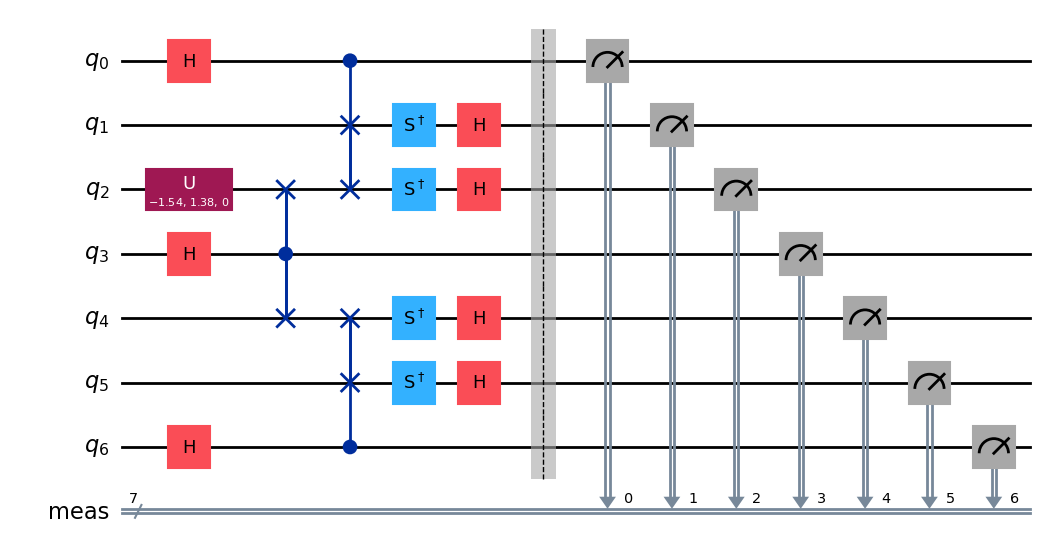

In [6]:
build_tomography_set(build_circuit(*states[0]))[1].draw('mpl')

In [7]:
ibm_brisbane = service.get_backend('ibm_brisbane')

In [8]:
circuits_to_send = list(itertools.chain.from_iterable([
        circuit for circuit in [
            build_tomography_set(build_circuit(theta, phi)) for theta, phi in states
        ]
    ]
))

circuits_to_send = [transpile(circuit, ibm_brisbane) for circuit in circuits_to_send]

In [9]:
def get_all_physical_qubits(circuit_list: list[QuantumCircuit]) -> set[int]:
    all_indices = set()
    for circ in circuit_list:    
        measurement_indices = [instr[1][0]._index for instr in circ.data if instr[0].name == 'measure']
        all_indices = all_indices.union(measurement_indices)
    return all_indices


def get_mitigation_circuits(circuit_list: list[QuantumCircuit]) -> list[QuantumCircuit]:

    physical_qubits = get_all_physical_qubits(circuit_list)

    num_qubits = len(physical_qubits)
    all_0 = QuantumCircuit(127, num_qubits)
    all_0.measure(physical_qubits, range(num_qubits))

    all_1 = QuantumCircuit(127, num_qubits)
    all_1.x(physical_qubits)
    all_1.measure(physical_qubits, range(num_qubits))

    return [all_0, all_1]

In [10]:
circuits_to_send = get_mitigation_circuits(circuits_to_send) + circuits_to_send

In [11]:
hardware_job = ibm_brisbane.run(circuits=circuits_to_send)

In [12]:
print(f"Hardware job ID: {hardware_job.job_id()}")

Hardware job ID: cw6g3gyggr6g0087cc5g


---

In [13]:
result = hardware_job.result().get_counts()

### Calculate Unmitigated Fidelities

In [14]:
def get_signal_qubit_idx_from_measurement_outcome(bit_string: str) -> int:
    if bit_string[3] == '0':
        if bit_string[6] == '0':
            return 4
        return 5
    else:
        if bit_string[0] == '0':
            return 2
        return 1


def get_xyz_counts_for_circuit(counts_list: list) -> tuple[dict]:
    output = []
    for counts in counts_list:
        counts_dict = {}
        
        counts_dict['0'] = sum(count for bit_string, count in counts.items() if bit_string[get_signal_qubit_idx_from_measurement_outcome(bit_string)] == '0')
        counts_dict['1'] = sum(count for bit_string, count in counts.items() if bit_string[get_signal_qubit_idx_from_measurement_outcome(bit_string)] == '1')
        
        output.append(counts_dict)
    
    return tuple(output)


def print_unmitigated_fidelities_combined(counts, theta, phi):

    qubit = density_op_from_counts_dict(*get_xyz_counts_for_circuit(counts))

    print(get_xyz_counts_for_circuit(counts))
    print(qubit)

    psi = gen_qubit(theta, phi)

    fidelity_q = state_fidelity(qubit, psi)

    print(f'State fidelity from combined counts: {fidelity_q}\n')

In [15]:
print_unmitigated_fidelities_combined(result[2:5], *states[0])
print_unmitigated_fidelities_combined(result[5:8], *states[1])
print_unmitigated_fidelities_combined(result[8:11], *states[2])

({'0': 886, '1': 3114}, {'0': 1155, '1': 2845}, {'0': 2678, '1': 1322})
[[ 0.669+0.j    -0.279+0.211j]
 [-0.279-0.211j  0.331+0.j   ]]
State fidelity from combined counts: 0.7662658173336112

({'0': 1926, '1': 2074}, {'0': 2359, '1': 1641}, {'0': 3350, '1': 650})
[[ 0.838+0.j   -0.018-0.09j]
 [-0.018+0.09j  0.162+0.j  ]]
State fidelity from combined counts: 0.785069746333225

({'0': 1704, '1': 2296}, {'0': 1909, '1': 2091}, {'0': 970, '1': 3030})
[[ 0.242+0.j    -0.074+0.023j]
 [-0.074-0.023j  0.758+0.j   ]]
State fidelity from combined counts: 0.7125605404159454



### Calculate Mitigation Fidelities

In [16]:
# Gets the map from a physical qubit to a classical bit for the mitigation calibration matrices
def get_qubit_to_clbit_mappings_for_mitigation(circuit: QuantumCircuit) -> dict[int, int]:
    return dict(
        ((instr[1][0]._index, instr[2][0]._index) for instr in circuit.data if instr[0].name == 'measure')
    )

# Gets the map from physical qubit to mitigation matrix
def get_assignment_matrices(mappings: dict, counts_0: dict, counts_1: dict) -> dict[int, ndarray]:

    output = {}

    for physical_qubit, classical_bit in mappings.items():
        
        # Determine zero state for assignment matrix
        result_0 = sum([count for bit_string, count in counts_0.items() if bit_string[classical_bit] == '0'])
        result_1 = sum([count for bit_string, count in counts_0.items() if bit_string[classical_bit] == '1'])
        
        # Calculate zero ket
        zero_ket = array([[result_0], 
                          [result_1]]) / (result_0 + result_1)
        
        # Determine one state for assignment matrix
        result_0 = sum([count for bit_string, count in counts_1.items() if bit_string[classical_bit] == '0'])
        result_1 = sum([count for bit_string, count in counts_1.items() if bit_string[classical_bit] == '1'])
        
        # Calculate zero ket
        one_ket = array([[result_0], 
                         [result_1]]) / (result_0 + result_1)
        
        assignment_matrix = numpy.concatenate([zero_ket, one_ket], axis=1)

        output[physical_qubit] = assignment_matrix
    
    return output

# Get the list of physical qubits in the same order as the classical bits 
def get_qubits_in_clbit_order(circuit: QuantumCircuit) -> list[int]:
    
    cl_bit_to_qbit_map = dict((instr[2][0]._index, instr[1][0]._index) for instr in circuit.data if instr[0].name == 'measure')

    return [*cl_bit_to_qbit_map.values()]
    

# Get the tensor of all mitigation matrices in the correct order for each circuit
def get_mitigation_matrix(circuit: QuantumCircuit, assignment_mappings: dict) -> ndarray:
    ordered_physical_qubits = get_qubits_in_clbit_order(circuit)

    ordered_physical_qubits.reverse()

    assignment_matrices = [assignment_mappings[qubit] for qubit in ordered_physical_qubits]

    return tens(*(scipy.linalg.inv(mat) for mat in assignment_matrices))


def get_bit_strings(count: int) -> list[str]:
    return [''.join(bits) for bits in itertools.product(['0', '1'], repeat=count)]


def get_corrected_counts(circuit: QuantumCircuit, counts_for_mitigation: dict, assignment_mappings: dict, num_qubits: int) -> dict[str, int]:
    bit_strings = get_bit_strings(num_qubits)

    counts_list = []
    for bit_string in bit_strings:
        counts_list.append(counts_for_mitigation[bit_string] if bit_string in counts_for_mitigation else 0)
    
    # Get vector of counts
    counts_vector = numpy.concatenate(
        array([[count for count in counts_list]]),
        axis=0
    )

    mitigation_matrix = get_mitigation_matrix(circuit, assignment_mappings)
    
    # Multiply by mitigation matirx
    corrected_vector = mitigation_matrix @ counts_vector
    corrected_vector = corrected_vector.astype(int)
    
    output = {}
    for idx, bit_string in zip(range(2**num_qubits), bit_strings):
        output[bit_string] = int(corrected_vector[idx])
    
    return output

In [17]:
# Get list of qubit to clbit mappings for the mitigation circuits.
mitigation_mappings = get_qubit_to_clbit_mappings_for_mitigation(circuits_to_send[0])

# Calculate assignment matrices for each qubit. 
assignment_matrices = get_assignment_matrices(mitigation_mappings, result[0], result[1])

In [18]:
def print_mitigated_fidelities_combined(circuits, counts, assignment_matrices, num_qubits, theta, phi):

    mitigated_counts = []

    for circuit, count in zip(circuits, counts):
        mitigated_counts.append(get_corrected_counts(circuit, count, assignment_matrices, num_qubits))

    qubit = density_op_from_counts_dict(*get_xyz_counts_for_circuit(mitigated_counts))
    
    print(get_xyz_counts_for_circuit(mitigated_counts))
    print(qubit)

    psi = gen_qubit(theta, phi)

    fidelity_q = state_fidelity(qubit, psi)

    print(f'Mitigated state fidelity from combined counts: {fidelity_q}\n')

In [19]:
print_mitigated_fidelities_combined(circuits_to_send[2:5], result[2:5], assignment_matrices, 7, *states[0])
print_mitigated_fidelities_combined(circuits_to_send[5:8], result[5:8], assignment_matrices, 7, *states[1])
print_mitigated_fidelities_combined(circuits_to_send[8:11], result[8:11], assignment_matrices, 7, *states[2])

({'0': 811, '1': 3128}, {'0': 1064, '1': 2870}, {'0': 2654, '1': 1292})
[[ 0.673+0.j   -0.294+0.23j]
 [-0.294-0.23j  0.327+0.j  ]]
Mitigated state fidelity from combined counts: 0.7872904907442126

({'0': 1880, '1': 2058}, {'0': 2337, '1': 1596}, {'0': 3360, '1': 590})
[[ 0.851+0.j    -0.023-0.094j]
 [-0.023+0.094j  0.149+0.j   ]]
Mitigated state fidelity from combined counts: 0.7977934160277171

({'0': 1652, '1': 2281}, {'0': 1866, '1': 2069}, {'0': 866, '1': 3084})
[[ 0.219+0.j    -0.08 +0.026j]
 [-0.08 -0.026j  0.781+0.j   ]]
Mitigated state fidelity from combined counts: 0.7309744775800855

